Software developers/programmers are a set of people, without whom the world cannot survive in 21st century. 
Hence, I was interested in finding out few important facts about Software developers using the Stackoverflow survey results, which were readily available. 

These include;

    Is collaborating with remote peers harder than those on site?
    
    What is the mostly used IDE?
    
    Things which matter for Career Satisfaction
    
Thus, Cross-Industry Standard Process for Data Mining (CRISP-DM) was used to find answers for above questions. Please find the steps followed and results received in each analysis.
    

In [17]:
#first we will read in the csv files and have a look at the data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib inline

df = pd.read_csv('./survey_results_public.csv')
schema = pd.read_csv('./survey_results_schema.csv')
df.head()

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,Strongly disagree,Male,High school,White or of European descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,NaN,NaN
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,Strongly disagree,Male,A master's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,NaN,37500.0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A professional degree,White or of European descent,Somewhat agree,Agree,Disagree,Agree,113750.0,NaN
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A doctoral degree,White or of European descent,Agree,Agree,Somewhat agree,Strongly agree,NaN,NaN
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
df.shape

(19102, 154)

Thus, 19102 responses are there for 154 various questions.

### 1.Remote Working

Here I'm trying to figure out whether **respondants who mostly work remotely have a different view point to that of non/rare remote workers, on collaborating with peers remotely versus on site**

In the dataset, there are 2 columns which relate to working remotely; **HomeRemote and CollaborateRemote**

In [23]:
#here we're getting the descriptions of HomeRemote and CollaborateRemote columns

def get_description(column_name, schema=schema):
    '''
    INPUT - schema - pandas dataframe with the schema of the developers survey
            column_name - string - the name of the column you would like to know about
    OUTPUT - 
            desc - string - the description of the column
    '''
    desc = list(schema[schema['Column']==column_name]['Question'])[0]
    return desc

print(get_description('CollaborateRemote'))
print(get_description('HomeRemote'))

It's harder to collaborate with remote peers than those on site
How often do you work from home or remotely?


In [18]:
#make a deep copy of the dataframe, thus, same original dataframe could be used for analysing other questions
remote_df = df.copy()

#it's important to find out how many values are missing in HomeRemote column
#isnull() is used for this purpose, it returns True if the value is missing and False otherwise

print(sum(remote_df.HomeRemote.isnull()==1))  #count of missing values in HomeRemote column

print(sum(remote_df.HomeRemote.isnull()==0))  #count of present valuse in HomeRemote column

2631
16471


Let's take a look at HomeRemote column in more detail to find out the set of values in that column

A few days each month                                      5876
Never                                                      5288
NaN                                                        2631
All or almost all the time (I'm full-time remote)          1922
Less than half the time, but at least one day each week    1464
More than half, but not all, the time                       676
It's complicated                                            633
About half the time                                         612
Name: HomeRemote, dtype: int64


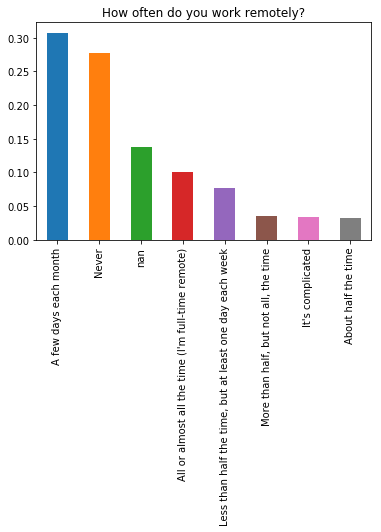

In [21]:
remote_working_vals = remote_df.HomeRemote.value_counts(dropna=False)

print(remote_working_vals)

#below is a bar chart of the proportion of individuals in each remote working category 

(remote_working_vals/remote_df.shape[0]).plot(kind="bar");
plt.title("How often do you work remotely?");

Let's take a look at CollaborateRemote column in more detail to find out the set of values in that column

NaN                  7972
Somewhat agree       3404
Agree                3388
Disagree             2374
Strongly agree       1341
Strongly disagree     623
Name: CollaborateRemote, dtype: int64


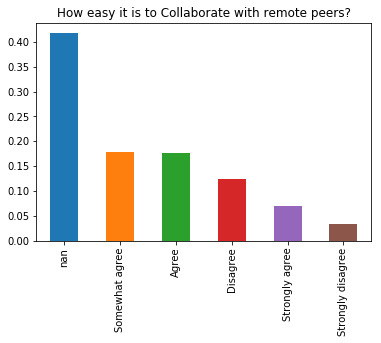

In [25]:
collab_remote = remote_df.CollaborateRemote.value_counts(dropna=False)

print(collab_remote)

(collab_remote/remote_df.shape[0]).plot(kind="bar");
plt.title("How hard it is to Collaborate with remote peers?");

According to above graphs, it is clear that around 14% and 42% values are missing in HomeRemote and CollaborateRemote columns respectively. Hence, it's important to do some data preparation to handle missing values.

When it comes to missing values in HomeRemote column, I believe respondants have skipped that question because
they are not much familiar with this concept. Hence, I'm categorizing them with Respondants who don't work remotely.

However, 


In [27]:
# now respondants of the survey are divided into 2 main categories based on the time they work remotely
# 1. Respondants who work remote often (wor)
# 2. Respondants who don't work remotely/very rarely

remote_status = ['All or almost all the time (I''m full-time remote)','More than half, but not all, the time','About half the time ']
non_remote_status = ['NaN', 'A few days each month','Never','Less than half the time, but at least one day each week','It''s complicated']

def works_remotely(home_remote_str):
    '''
    INPUT
        home_remote_str - a string of one of the values from the HomeRemote column
    
    OUTPUT
        return 1 if the string is  in remote_status list
        return 0 otherwise
    
    '''
    if home_remote_str in remote_status:
        return 1
    else:
        return 0


In [28]:
remote_df['RemoteWorker']=remote_df["HomeRemote"].apply(works_remotely)

In [30]:
remote_df.RemoteWorker.value_counts(dropna=False)

0    18426
1      676
Name: RemoteWorker, dtype: int64

Now we would like to find out if the proportion of respondants who work remote mostly, feel differently than those that do not. 

Store a dataframe of only the individual's who had RemoteWorker equal to 1 in remote_rows. Similarly, store a dataframe of only the RemoteWorker equal to 0 values in non_remote_rows.

In [7]:
remote_rows = df[df['RemoteWorker']==1]      # Subset df to only those who work remote often
non_remote_rows = df[df['RemoteWorker']==0]  # Subset df to only those who don't work remotely/very rarely

In [8]:
def total_count(df, col1, col2, look_for):
    '''
    INPUT:
    df - the pandas dataframe you want to search
    col1 - the column name you want to look through
    col2 - the column you want to count values from
    look_for - a list of strings you want to search for in each row of df[col]

    OUTPUT:
    new_df - a dataframe of each look_for with the count of how often it shows up
    '''
    new_df = defaultdict(int)
    #loop through list of ed types
    for val in look_for:
        #loop through rows
        for idx in range(df.shape[0]):
            #if the ed type is in the row add 1
            if val in df[col1][idx]:
                new_df[val] += int(df[col2][idx])
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = [col1, col2]
    new_df.sort_values('count', ascending=False, inplace=True)
    return new_df

In [9]:
#possible values in CollaborateRemote column
possible_vals = ["Somewhat agree", "Agree", "Disagree", "Strongly agree", "Strongly disagree"]

def clean_and_plot(df, title, plot=True):
    '''
    INPUT 
        df - a dataframe holding the CollaborateRemote column
        title - string the title of your plot
        axis - axis object
        plot - bool providing whether or not you want a plot back
        
    OUTPUT
        remote_df - a dataframe with the count of how many individuals
        Displays a plot of pretty things related to the CollaborateRemote column.
    '''
    view = df['CollaborateRemote'].value_counts().reset_index()
    view.rename(columns={'index': 'method', 'CollaborateRemote': 'count'}, inplace=True)
    remote_df = total_count(view, 'method', 'count', possible_vals)

    remote_df.set_index('method', inplace=True)
    if plot:
        (remote_df/remote_df.sum()).plot(kind='bar', legend=None);
        plt.title(title);
        plt.show()
    props_remote_df = remote_df/remote_df.sum()
    return props_remote_df

In [10]:
remote_perc = clean_and_plot(remote_rows, 'Remote Workers Responds', plot=False)
non_remote_perc = clean_and_plot(non_remote_rows, 'Non Remote Workers Responds', plot=False)

comp_df = pd.merge(remote_perc, non_remote_perc, left_index=True, right_index=True)
comp_df.columns = ['remote_perc', 'non_remote_perc']
comp_df['Diff_Remote_Vals'] = comp_df['remote_perc'] - comp_df['non_remote_perc']
comp_df.style.bar(subset=['Diff_Remote_Vals'], align='mid', color=['#d65f5f', '#5fba7d'])

,remote_perc,non_remote_perc,Diff_Remote_Vals
method,,,
Somewhat agree,0.340369,0.304623,0.0357466
Disagree,0.295515,0.210399,0.0851155
Agree,0.237467,0.306762,-0.0692951
Strongly disagree,0.0686016,0.0555297,0.0130719
Strongly agree,0.0580475,0.122686,-0.0646388


In [11]:
# by considering 'Somewhat agree', 'Agree' and 'Strongly agree' as Agree
remote_workers_who_agree = 0.340369 + 0.237467 + 0.0580475
remote_workers_who_agree

0.6358835

In [12]:
non_remote_workers_who_agree = 0.304623 + 0.306762 + 0.122686
non_remote_workers_who_agree

0.7340709999999999

When comparing above figures, it seems that **a higher percentage of people (73%), who don't work much remotely think, it's harder to collaborate with remote peers than on site peers. But a lesser percentage of people (64%) who are actually remote workers agrees that, it's hard to collaborate with peers remotely.**

This might be due to the **lack of experience of non-remote workers.**

Thus, if an IT company is moving towards working remotely, it's important for that company to raise awareness and introduce flexible/easy to use collaborative tools to employees to change their mindset.

### 2.Popular IDE

Here I'm trying to find out the most popular IDE among the respondants of StackOverflow survey.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('./survey_results_public.csv')
df.head()

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,Strongly disagree,Male,High school,White or of European descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,NaN,NaN
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,Strongly disagree,Male,A master's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,NaN,37500.0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A professional degree,White or of European descent,Somewhat agree,Agree,Disagree,Agree,113750.0,NaN
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A doctoral degree,White or of European descent,Agree,Agree,Somewhat agree,Strongly agree,NaN,NaN
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df.shape[0] #number of rows in the dataset

19102

First, lets have a look at the values in IDE column

In [16]:
df.IDE.value_counts()

Notepad++; Visual Studio                                                                                       610
Visual Studio                                                                                                  578
Vim                                                                                                            501
Notepad++; Visual Studio; Visual Studio Code                                                                   391
Visual Studio; Visual Studio Code                                                                              380
Sublime Text                                                                                                   344
Atom                                                                                                           180
Emacs                                                                                                          173
Eclipse                                                                         

In [17]:
df.IDE[:20]   #first 20 values in IDE column

0                                           Atom; Xcode
1     Atom; Notepad++; Vim; PyCharm; RubyMine; Visua...
2                           Sublime Text; Vim; IntelliJ
3     Notepad++; Sublime Text; TextMate; Vim; IPytho...
4                                                   NaN
5                                            Emacs; Vim
6     Sublime Text; IPython / Jupyter; Visual Studio...
7                                                   Vim
8                Vim; Visual Studio; Visual Studio Code
9              Coda; Sublime Text; Visual Studio; Xcode
10                                        Visual Studio
11                                                  NaN
12                                                  NaN
13                                                  Vim
14                                         Emacs; Xcode
15                             Notepad++; Visual Studio
16                                           Emacs; Vim
17                                           Ema

It seems that some people haven't responded this survey question. (some rows have NaN)
Thus, some cleaning is required.

Further, this column has different combinations of answers. Thus, it's important for us to find out the different values, which were provided in the survey.

In order to do that, lets first remove the rows which are missing IDE.

In [18]:
df_drop = df.dropna(subset=['IDE'], axis=0)
df_drop.shape[0]   #number of rows after dropping rows with missing IDE values

13197

Around 5905 people haven't responded to this particular question.

Now it's time to find out the set of values which were available on the questionnare.

In order to do that, we have to do some processing.

In [19]:
arr = df_drop.IDE.unique()   #get the unique values in IDE column
arr

array(['Atom; Xcode',
       'Atom; Notepad++; Vim; PyCharm; RubyMine; Visual Studio; Visual Studio Code',
       'Sublime Text; Vim; IntelliJ', ...,
       'Atom; Emacs; Sublime Text; IntelliJ; PHPStorm; PyCharm',
       'Emacs; Notepad++; Android Studio; IPython / Jupyter; RStudio; Visual Studio',
       'Atom; Emacs; Eclipse; IntelliJ'], dtype=object)

In [20]:
ide_types = []
split_arr = []

for a in arr:
    split_arr = a.split('; ')
    
    for split_s in split_arr:
        if split_s not in ide_types:
            ide_types.append(split_s)
    
print(ide_types)

['Atom', 'Xcode', 'Notepad++', 'Vim', 'PyCharm', 'RubyMine', 'Visual Studio', 'Visual Studio Code', 'Sublime Text', 'IntelliJ', 'TextMate', 'IPython / Jupyter', 'NetBeans', 'Emacs', 'Coda', 'PHPStorm', 'Android Studio', 'RStudio', 'Komodo', 'Eclipse', 'Light Table', 'Zend']


Above is the list of IDEs which were available in the survey.

Below, we're creating a dictionary to hold the usage of each IDE, against the IDE name. Usage of all IDEs are initialized to zero (0).

In [21]:
ide_count_map = {}
  
for t in ide_types:
    ide_count_map.update( {t : 0} )
    
print(ide_count_map)

{'Atom': 0, 'Xcode': 0, 'Notepad++': 0, 'Vim': 0, 'PyCharm': 0, 'RubyMine': 0, 'Visual Studio': 0, 'Visual Studio Code': 0, 'Sublime Text': 0, 'IntelliJ': 0, 'TextMate': 0, 'IPython / Jupyter': 0, 'NetBeans': 0, 'Emacs': 0, 'Coda': 0, 'PHPStorm': 0, 'Android Studio': 0, 'RStudio': 0, 'Komodo': 0, 'Eclipse': 0, 'Light Table': 0, 'Zend': 0}


In [22]:
def get_ide_counts(df, ide_count_map):
    '''
    INPUT
    df - pandas dataframe
    ide_count_map - a dictionary with ide names and counts initialized to 0
    
    OUTPUT
    ide_map - a dictionary containing counts for each ide (key: ide, value: count)
    
    Steps:
    1.Slice out IDE column from the dataframe
    2.For each value in the column, split each IDE name
    3.For each IDE name in the splitted list, update the usage/count in dictionary 
    '''
    
    df_ide = df['IDE']   #slice out IDE column
    
    for val in df_ide:
        split_arr = val.split('; ')
        
        for ide in split_arr:  
            ide_count_map[ide] = ide_count_map[ide] + 1
            
    return ide_count_map

get_ide_counts(df_drop, ide_count_map)

{'Android Studio': 1929,
 'Atom': 2373,
 'Coda': 82,
 'Eclipse': 2620,
 'Emacs': 789,
 'IPython / Jupyter': 733,
 'IntelliJ': 2786,
 'Komodo': 81,
 'Light Table': 25,
 'NetBeans': 906,
 'Notepad++': 4405,
 'PHPStorm': 995,
 'PyCharm': 1205,
 'RStudio': 390,
 'RubyMine': 233,
 'Sublime Text': 3505,
 'TextMate': 188,
 'Vim': 3739,
 'Visual Studio': 5061,
 'Visual Studio Code': 2691,
 'Xcode': 1335,
 'Zend': 44}

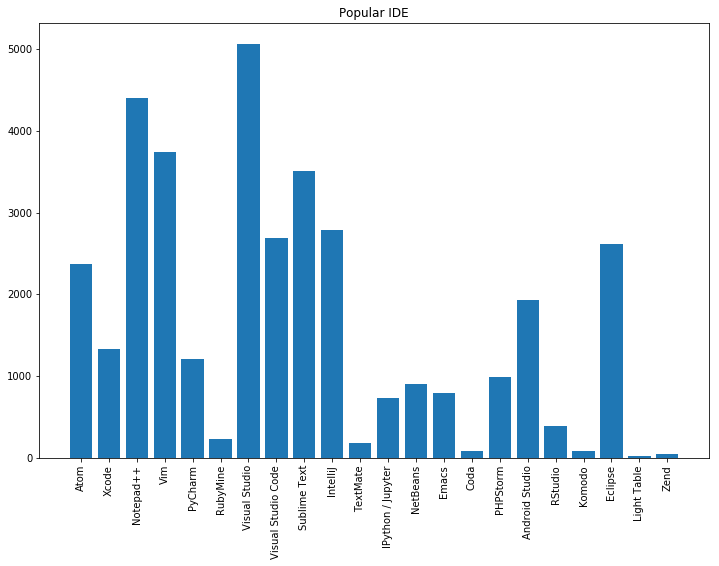

In [23]:
ide_names = list(ide_count_map.keys())
values = list(ide_count_map.values())

#tick_label does the some work as plt.xticks()
plt.bar(range(len(ide_count_map)),values,tick_label=ide_names)
plt.title('Popular IDE')

N = 2
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*N, plSize[1]*N) )

plt.xticks(rotation='vertical')
plt.show()

In [24]:
sorted(ide_count_map.items(), key=lambda x: x[1], reverse=True)

[('Visual Studio', 5061),
 ('Notepad++', 4405),
 ('Vim', 3739),
 ('Sublime Text', 3505),
 ('IntelliJ', 2786),
 ('Visual Studio Code', 2691),
 ('Eclipse', 2620),
 ('Atom', 2373),
 ('Android Studio', 1929),
 ('Xcode', 1335),
 ('PyCharm', 1205),
 ('PHPStorm', 995),
 ('NetBeans', 906),
 ('Emacs', 789),
 ('IPython / Jupyter', 733),
 ('RStudio', 390),
 ('RubyMine', 233),
 ('TextMate', 188),
 ('Coda', 82),
 ('Komodo', 81),
 ('Zend', 44),
 ('Light Table', 25)]

According to the above analysis, 5 mostly used IDEs are; Visual Studio, Notepad++, Vim, Sublime Text and IntelliJ

### 3. Career Satisfaction

Here I'm trying to find out top indicators (different variables which matters) for Career Satisfaction.

In [3]:
#First lets take a look at the quantitative fields

df.describe()

,Respondent,CareerSatisfaction,JobSatisfaction,HoursPerWeek,StackOverflowSatisfaction,Salary,ExpectedSalary
count,19102.000000,16102.000000,15253.000000,7721.000000,13452.000000,5009.000000,818.000000
mean,9551.500000,7.343932,7.000721,3.685922,8.357865,58341.398571,32231.521687
std,5514.416757,1.919330,2.128648,7.330691,1.405546,40753.384986,28543.877274
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4776.250000,6.000000,6.000000,0.000000,8.000000,27956.989247,4716.459735
50%,9551.500000,8.000000,7.000000,1.000000,8.000000,51612.903226,29784.946237
75%,14326.750000,9.000000,8.000000,3.000000,9.000000,83333.333333,50000.000000
max,19102.000000,10.000000,10.000000,40.000000,10.000000,195000.000000,120000.000000


In [4]:
#here I'm making a deep copy of the dataframe
career_df = df.copy()

According to CRISP-DM, we need to perform some data wrangling.

Although this dataset has 19102 records, question related to CareerSatisfaction has been answered only by 16102 respondants. Which means, around 3000 have not answered it. That is around 15.71% and it is a significant portion of the respondants. Thus, I'm not planning to impute values for Career Satisfaction. Rather, I will **drop the rows with missing CareerSatisfaction.**

Since Respondant column is just like an index, I will drop that too..

Further, **ExpectedSalary column will also be dropped**, because only 818 people (4.28%) have responded to it. Thus, Expected Salary column could be considered insignificant.

But, for other **Quantitative variables**, I'm imputing with **mean of each column**, because it's the most common way and an unbiased way to fill up missing values in numerical fields.

**One Hot Encoding** is used for **Categorical variables.**

Why I chose One Hot Encoding is because, it can be easily interpreted and due to the flexibility in influence of variable on the response.


In [5]:
def clean_data(dataframe):
    '''
    INPUT
    dataframe - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    Perform to obtain the correct X and y objects
    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with no Career Satisfaction
    2. Create X as all the columns that are not the CareerSatisfaction column
    3. Create y as the CareerSatisfaction column
    4. Drop the CareerSatisfaction, Respondent, and the ExpectedSalary columns from X
    5. For each numeric variable in X, fill the column with the mean value of the column.
    6. Create dummy columns for all the categorical variables in X, drop the original columns
    '''
    
    dataframe = dataframe.dropna(subset=['CareerSatisfaction'], axis=0)
    X = dataframe.drop(labels='CareerSatisfaction', axis=1)
    y = dataframe['CareerSatisfaction']
    
    X = X.drop(labels=['Respondent','ExpectedSalary'], axis=1)
    
    numeric_cols = X.select_dtypes(include=['int','float']).columns
    
    for col in numeric_cols:
        X[col].fillna(X[col].mean(), inplace=True)
    
    cat_cols = X.select_dtypes(include=['object']).columns
    
    for col in cat_cols:
        X = pd.concat([X.drop(col,axis=1),pd.get_dummies(X[col],prefix=col,prefix_sep='_',dummy_na=False,drop_first=True)],axis=1)
    
    return X, y
    
    
#Use the function to create X and y
X, y = clean_data(career_df)   

In [6]:
X.shape

(16102, 21306)

Using all of the 21306 variables will drastically overfit the training data. Hence, we will try to find the optimal model by trying out with different cutoff values.

In [7]:
#cutoffs here pertains to the number of missing values allowed in the used columns.
#Therefore, lower values for the cutoff provides more predictors in the model and vice versa
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 25]

In [8]:
def find_optimal_lm_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default True, to plot result

    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:

        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        lm_model = LinearRegression(normalize=True)
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)

        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)

    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()

    best_cutoff = max(results, key=results.get)

    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)

    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test

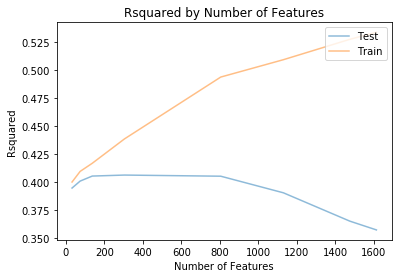

In [11]:
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X, y, cutoffs)

In [12]:
r2_scores_test

[0.3945223190161258,
 0.4007186553783617,
 0.40521115476278946,
 0.40609782221758906,
 0.4050818831371569,
 0.39027191131800365,
 0.3649703510550033,
 0.35713718669100614]

In [13]:
r2_scores_train

[0.39988999211421195,
 0.4093679327429901,
 0.4166318378276169,
 0.43835016386651793,
 0.4935901393015154,
 0.5090723023881971,
 0.527264497602565,
 0.533590455858793]

According rsquared values of test data, the maximum is 0.40609782221758906. It is recorded when cutoff is 1000 and number of features lies somewhere between 100 to 200.

The default penalty on coefficients using linear regression in sklearn is a ridge (also known as an L2) penalty. Because of this penalty, and that all the variables were normalized, we can look at the size of the coefficients in the model as an indication of the impact of each variable on the CareerSatisfaction. 

**The larger the coefficient, the larger the expected impact on CareerSatisfaction.**

In [14]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#look at the top 20 results
coef_df.head(20)

,est_int,coefs,abs_coefs
4,Professional_Professional developer,0.628331,0.628331
0,JobSatisfaction,0.519891,0.519891
189,DifficultCommunication_Strongly disagree,0.345434,0.345434
5,Professional_Professional non-developer who so...,0.304543,0.304543
15,"EmploymentStatus_Independent contractor, freel...",0.286303,0.286303
32,CompanyType_Publicly-traded corporation,0.252075,0.252075
10,Country_India,-0.246024,0.246024
77,KinshipDevelopers_Disagree,-0.240376,0.240376
119,AssessJobProduct_Not very important,-0.226778,0.226778
8,"ProgramHobby_Yes, both",0.218092,0.218092


In [15]:
df.DifficultCommunication.value_counts()

Disagree             5814
Somewhat agree       2349
Strongly disagree    1978
Agree                 885
Strongly agree        184
Name: DifficultCommunication, dtype: int64

In [16]:
df.Professional.value_counts()

Professional developer                                  13774
Student                                                  2821
Professional non-developer who sometimes writes code     1782
None of these                                             368
Used to be a professional developer                       357
Name: Professional, dtype: int64

According to the coefficients, **Professionalism** seems to have a high impact on CareerSatisfaction. Further, **JobSatisfaction** and **Communication Skills** also plays a vital role. 